# Rock Paper Scissors Hand Gesture Classification
### Dikoding - Belajar Machine Learning untuk Pemula
Oleh: Diah Ayu Setyaningsih

In [1]:
import time
start = time.time()

## Import Module

In [20]:
import os
import math
import shutil
import cv2
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

## Import Dataset

In [3]:
!wget --no-check-certificate https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
!unzip ./rockpaperscissors.zip

# remove unnecessary folder
shutil.rmtree('./rockpaperscissors/rps-cv-images')

base_dir='./rockpaperscissors'

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: __MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._0CSaM2vL2cWX6Cay.png  
  inflating: rockpaperscissors/scissors/2DEYF

In [4]:
# !cat ./rockpaperscissors/README_rpc-cv-images.txt

## Preprocessing Function

In [5]:
def get_skin(img):
    """Capturing skin color on an image.
    # Arguments
        img = Numpy tensor with rank 3 (RGB image).
    # Returns
        Numpy tensor with the same shape (RGB image).
    """

    #convert image so cv2 can be implemented
    img = np.array(img, dtype = np.uint8)

    #convert to YCrCb format
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    #skin color range for YCbCr color space
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)

    #capturing skin on the image
    img[YCrCb_result!=0]=[0,0,0]

    # convert to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # rescale
    img=img/255.0
    return img

## Data Split dan Data Augmentation

In [6]:
datagen = ImageDataGenerator(vertical_flip=True,
                             horizontal_flip=True,
                             rotation_range=90,
                             zoom_range=[0.75,1.2],
                             validation_split=0.4,
                             preprocessing_function=get_skin)

train_generator = datagen.flow_from_directory(directory=base_dir,
                                              subset="training",
                                              target_size=(150, 150),
                                              color_mode="rgb",
                                              batch_size=32,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=42)

valid_generator = datagen.flow_from_directory(directory=base_dir,
                                              subset="validation",
                                              target_size=(150, 150),
                                              color_mode="rgb",
                                              batch_size=32,
                                              class_mode="categorical",
                                              shuffle=True,
                                              seed=42)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


### Show several train image

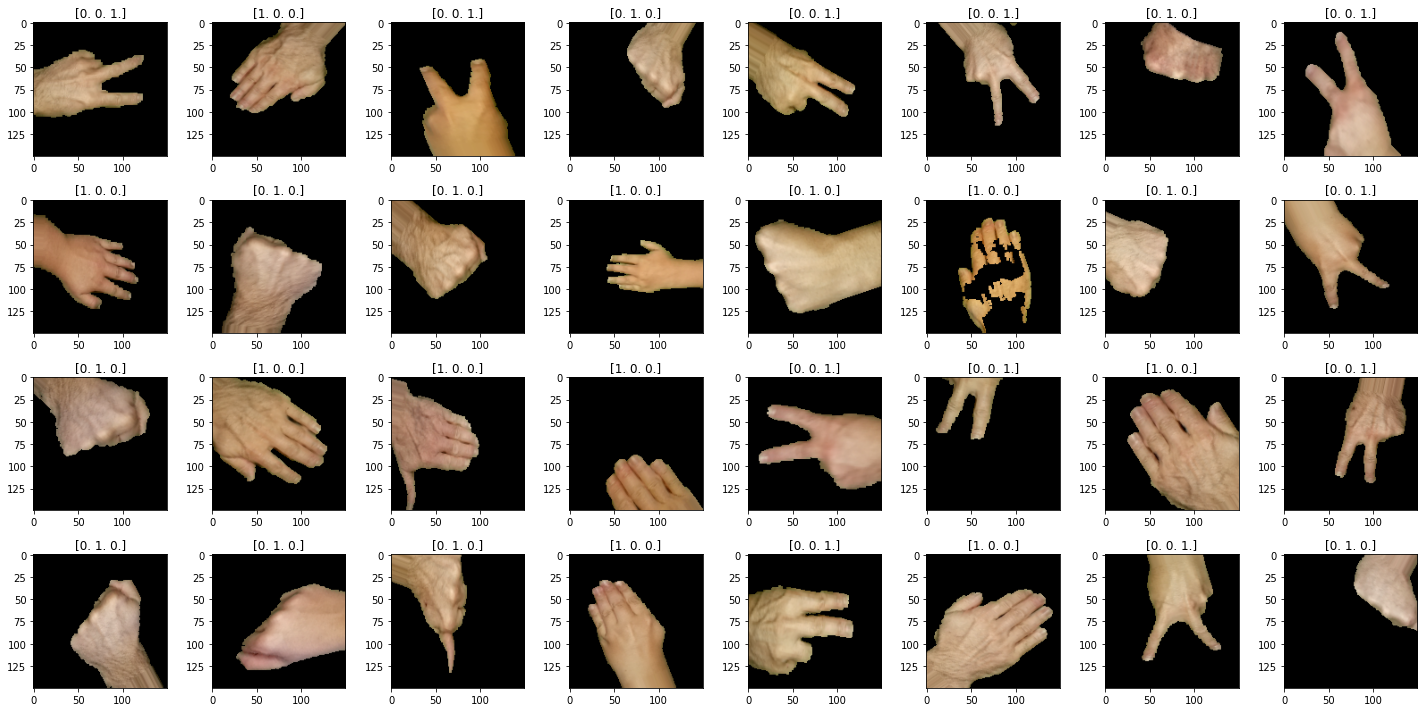

In [7]:
fig=plt.figure(figsize=(20, 10))
columns = 8
rows = 4

x, y = train_generator.next()

for i in range(0, columns*rows):
    axs=fig.add_subplot(rows, columns, i+1)
    axs.set_title(str(y[i]))
    img = x[i]
    plt.imshow(img)
plt.tight_layout()
plt.show()

## CNN Model

In [8]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150,3)))
model.add(MaxPool2D(pool_size=(2,2)))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

# hidden layer
model.add(Dense(128, activation='relu'))

# output layer
model.add(Dense(3, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)       

## Callbacks

In [9]:
# drop learning rate by 0.5 if val_loss not improve in 5 epoch
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=5,
                                   verbose=1,
                                   mode='auto')

# save model with best validation accuracy
checkpoint = ModelCheckpoint("weights.best.hdf5",
                             monitor='val_accuracy', 
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# to visualize training metrics on TensorBoard
tensorboard = TensorBoard(log_dir="./logs")

callbacks_list = [reduceLROnPlat, checkpoint, tensorboard]

## Training Model

In [10]:
train_step_size = math.ceil(train_generator.n/train_generator.batch_size)
valid_step_size = math.ceil(valid_generator.n/valid_generator.batch_size)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_step_size,
                              validation_data=valid_generator,
                              validation_steps=valid_step_size,
                              epochs=25,
                              callbacks=callbacks_list)

Epoch 1/25
42/42 [==============================] - 22s 520ms/step - loss: 0.9799 - accuracy: 0.5000 - val_loss: 0.6699 - val_accuracy: 0.6991

Epoch 00001: val_accuracy improved from -inf to 0.69908, saving model to weights.best.hdf5
Epoch 2/25
42/42 [==============================] - 17s 412ms/step - loss: 0.6722 - accuracy: 0.7154 - val_loss: 0.9903 - val_accuracy: 0.7746

Epoch 00002: val_accuracy improved from 0.69908 to 0.77460, saving model to weights.best.hdf5
Epoch 3/25
42/42 [==============================] - 17s 408ms/step - loss: 0.5256 - accuracy: 0.7816 - val_loss: 0.7994 - val_accuracy: 0.7963

Epoch 00003: val_accuracy improved from 0.77460 to 0.79634, saving model to weights.best.hdf5
Epoch 4/25
42/42 [==============================] - 18s 420ms/step - loss: 0.4720 - accuracy: 0.8105 - val_loss: 0.1675 - val_accuracy: 0.8593

Epoch 00004: val_accuracy improved from 0.79634 to 0.85927, saving model to weights.best.hdf5
Epoch 5/25
42/42 [==============================] -

### Open tensorboard

In [11]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 881), started 3:31:59 ago. (Use '!kill 881' to kill it.)

<IPython.core.display.Javascript object>

In [12]:
# !kill 2470

### Load best model

In [13]:
# load weight
model.load_weights("weights.best.hdf5")

# compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Predict New Image

### Download test file

In [14]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-LE_97rItx7wa2QbEBvZgIeYlaghXJ-V' -O test.rar
!unrar x ./test.rar

# filename list of test image
test = os.listdir('./test')

--2020-07-24 06:16:10--  https://docs.google.com/uc?export=download&id=1-LE_97rItx7wa2QbEBvZgIeYlaghXJ-V
Resolving docs.google.com (docs.google.com)... 74.125.69.139, 74.125.69.100, 74.125.69.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6a6jcui6ib90a7r25naj3dfhltvd10n2/1595571300000/18431793348103330468/*/1-LE_97rItx7wa2QbEBvZgIeYlaghXJ-V?e=download [following]
--2020-07-24 06:16:11--  https://doc-10-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6a6jcui6ib90a7r25naj3dfhltvd10n2/1595571300000/18431793348103330468/*/1-LE_97rItx7wa2QbEBvZgIeYlaghXJ-V?e=download
Resolving doc-10-ac-docs.googleusercontent.com (doc-10-ac-docs.googleusercontent.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to doc-10-ac-docs.googleusercontent.com (doc-10-ac-docs

### Check using original image

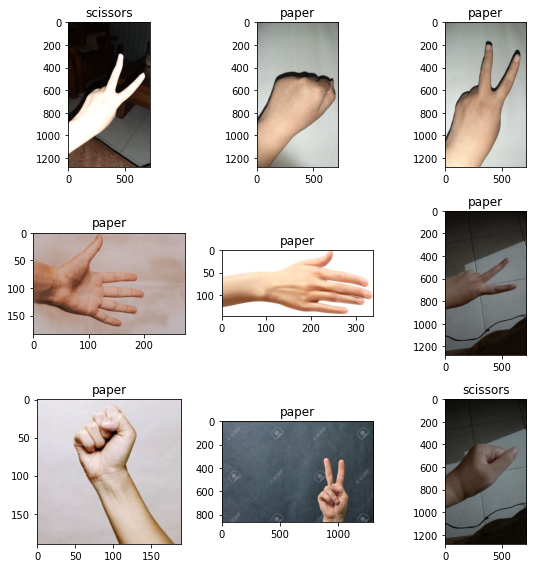

In [15]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    # load image
    path = os.path.join('./test', test[i-1])
    img = image.load_img(path)
    
    # preprocessing
    x = image.img_to_array(img)
    x = cv2.resize(x,(150,150))
    x = x/255.
    

    # predicting
    x = np.expand_dims(x, axis=0)
    x = np.vstack([x])
    predicted = model.predict(x)
    predicted_class_indices=np.argmax(predicted,axis=1)

    #get label
    if predicted_class_indices==0:
        label='paper'
    elif predicted_class_indices==1:
        label='rock'
    else:
        label='scissors'
    
    # show image
    axs=fig.add_subplot(rows, columns, i, label=label)
    axs.set_title(label)
    plt.imshow(img)

plt.tight_layout()
plt.show()


### Check using preprocessed image

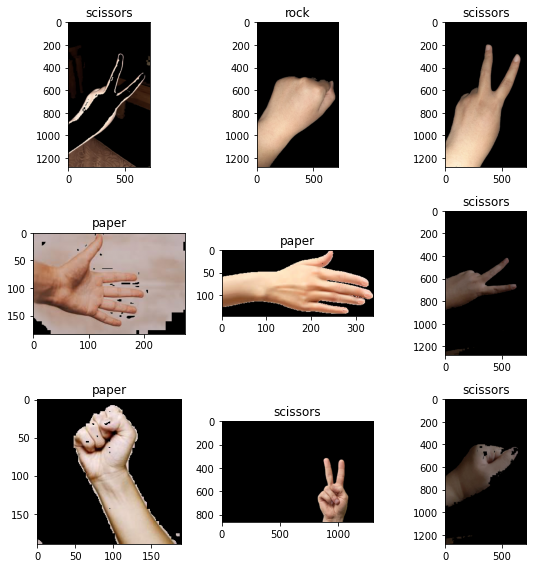

In [36]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    # load image
    path = os.path.join('./test', test[i-1])
    img = image.load_img(path,(150,150))

    # preprocessing
    img = image.img_to_array(img)
    img = get_skin(img)
    x = cv2.resize(img,(150,150))
    
    # predicting
    x = np.expand_dims(x, axis=0)
    x = np.vstack([x])
    predicted = model.predict(x)
    predicted_class_indices=np.argmax(predicted,axis=1)

    #get label
    if predicted_class_indices==0:
        label='paper'
    elif predicted_class_indices==1:
        label='rock'
    else:
        label='scissors'
    
    # show image
    axs=fig.add_subplot(rows, columns, i, label=label)
    axs.set_title(label)
    plt.imshow(img)

plt.tight_layout()
plt.show()


In [ ]:
print(time.time()-start)

2715.5879180431366


## Upload Image

uncomment code di bawah ini untuk upload dan memprediksi image

Saving download.jpg to download (5).jpg
Saving depositphotos_17505107-stock-photo-woman-hand-in-scissors-gesture.jpg to depositphotos_17505107-stock-photo-woman-hand-in-scissors-gesture (3).jpg
Saving WhatsApp Image 2020-07-20 at 21.57.57.jpeg to WhatsApp Image 2020-07-20 at 21.57.57 (2).jpeg


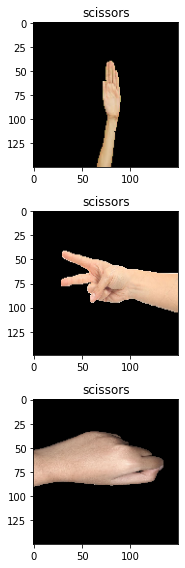

In [35]:
# # manual upload
# uploaded = files.upload()

# fig=plt.figure(figsize=(8, 8))
# columns = 1
# rows = len(uploaded.keys())

# for i, fn in enumerate(uploaded.keys()):
#     # load images
#     path = fn
#     img = image.load_img(path, target_size=(150,150))
    
#     #preprocess
#     img = image.img_to_array(img)
#     img = get_skin(img)
#     x = cv2.resize(img,(150,150))
#     x = np.expand_dims(x, axis=0)

#     # predicting
#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=10)
#     predicted_class_indices=np.argmax(predicted,axis=1)

#     #get label
#     if predicted_class_indices==0:
#         label='paper'
#     elif predicted_class_indices==1:
#         label='rock'
#     else:
#         label='scissors'

#     axs=fig.add_subplot(rows, columns, i+1, label=label)
#     axs.set_title(label)
#     plt.imshow(img)

# plt.tight_layout()
# plt.show()